# Tutorial on transfer learning from universal models

In this tutorial, we will improve the universal machine learning potential ANI-1ccx-gelu specifically on CH3NO2 molecule, which will be reflected in improved harmonic frequencies compared with experiment

In [1]:
import mlatom as ml 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Overview of the dataset

We take the datasets from https://doi.org/10.1021/acs.jctc.1c00249. There are 9001 training points with energies and forces at MP2/aug-cc-pVTZ level. 

In [2]:
# prepare the dataset
training_data = ml.data.molecular_database.load('CH3NO2_MP2_avtz.json',format='json')
print('Number of training points: ', len(training_data))

Number of training points:  9001


Text(0, 0.5, 'Number of entries')

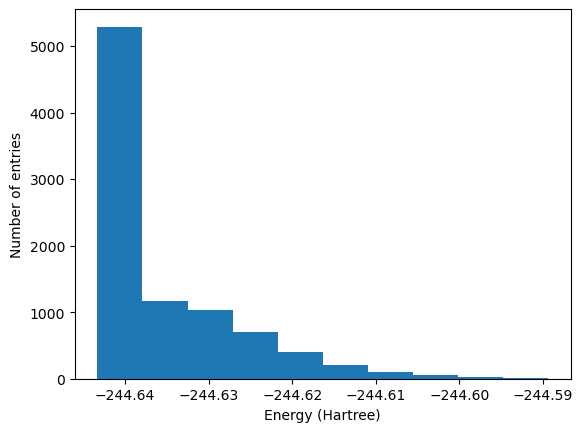

In [3]:
# plot the energy distribution
energies = training_data.get_properties('energy')
plt.hist(energies)
plt.xlabel('Energy (Hartree)')
plt.ylabel('Number of entries')

# Load universal model

In [6]:
ani1ccx_gelu = ml.models.methods(method='ANI-1ccx-gelu')
# ani = ml.models.methods(method='ANI-1ccx')
# ani = ml.models.methods(method='ANI-2x')

# Fine tune

There are several parameters we need to care about when transfer learning (though we have default settings in MLatom, you might want to customize the procedure yourself)

### Arguments to pass to `train()`

The arguments available can be found in manual for API about torchani interface. Here several key arguments are listed:

- `reset_energy_shifter [list, bool]`: Control how the self atomic energies will be extracted. By default we will use those extracted from the training data. If set to False, we will use those from pretrained models. If list, values inside will be used as the self atomic energies for scaling. 
- `file_to_save_model [str]`: The file name to save the retrained models. Defaul "{universal model name}_retrained.pt.cv{model index}"
- `verbose [bool or int]`: Control the information printed out when training. 1 will print out training procedure and 2 will print out metrics from training and validation. 
- `hyperparameters [dict]`: Control the training procedure, will explain in detail later.


### Parameters in `hyperparameters`

- `batch_size`: default 8
- `max_epochs`: default 100 for transfer learning
- `fixed_layers`: default 1 and 3 layer are fixed. 

In [ ]:
ani1ccx_gelu_tl = ani1ccx_gelu.train(
    molecular_database=training_data,
    property_to_learn='energy',
    xyz_derivative_property_to_learn = 'energy_gradients',
    # verbose=2,
    hyperparameters={
        'max_epochs':1000,
        'batch_size':512,
        # 'fixed_layers':[[0,4],[0,4],[0,4],[0,4]]
        }
)


Start retraining on model 0...

Start retraining on model 1...

Start retraining on model 2...

Start retraining on model 3...

Start retraining on model 4...

Start retraining on model 5...

Start retraining on model 6...

Start retraining on model 7...


After transfer learning, the models will be saved in the current directory either named in the combination of the universal model name plus 'retrained' or the user defined name for the model. You can still load them with torchani interface to do the simulations:

In [ ]:
# for loading one model
ani_tl_cv0 = ml.models.ani(model_file='ani1ccxgelu_retrained.pt.cv0')

# for loading multiple models as an ensemble
children = [
    ml.models.model_tree_node(
        name=f'nn{ii}', 
        model=ml.models.ani(model_file=f'ani1ccxgelu_retrained.pt.cv{ii}'), 
        operator='predict') 
    for ii in range(8)]
ani_tl_ensemble = ml.models.model_tree_node(
        name='nn', 
        children=children, 
        operator='average')

# Compare harmonic frequencies

In [8]:
def calculate_harmonic_frequency(
    calculator=None,
    initmol=None,
    opt_program='geometric', # do not use gaussian which currently cannot recognize the retrained method
    freq_program='pyscf',
     
):
    geomopt = ml.simulations.optimize_geometry( 
        model=calculator, 
        initial_molecule=initmol, 
        program=opt_program)
    optmol = geomopt.optimized_molecule
    ml.simulations.freq(
        model=calculator, 
        molecule=optmol,
        program=freq_program,)
    return optmol

In [24]:
# load initial molecule
initmol = ml.data.molecule.from_xyz_file('CH3NO2_init.xyz')

# load universal model
ani1ccx_gelu = ml.models.methods(method='ANI-1ccx-gelu')

In [25]:
# calculate harmonic frequency
freqmol_anigelu = calculate_harmonic_frequency(ani1ccx_gelu, initmol)
freqmol_anigelu_tl = calculate_harmonic_frequency(ani1ccx_gelu_tl, initmol)

In [26]:
# load performance table and check MAE
reference_table = pd.read_csv('CH3NO2_harmonic.csv')
reference_table['ANI-1ccx-gelu'] = freqmol_anigelu.frequencies
reference_table['ANI-1ccx-gelu-TL'] = freqmol_anigelu_tl.frequencies

print('MAE (cm-1) of harmonic frequencies compared to MP2:')
mae = abs(reference_table['ANI-1ccx-gelu'].astype(np.float32)-reference_table['MP2/avtz'].astype(np.float32)).mean()
print(f'ANI-1ccx-gelu: {mae}')
mae = abs(reference_table['ANI-1ccx-gelu-TL'].astype(np.float32)-reference_table['MP2/avtz'].astype(np.float32)).mean()
print(f'ANI-1ccx-gelu-tl: {mae}')


MAE (cm-1) of harmonic frequencies compared to MP2:
ANI-1ccx-gelu: 23.052539825439453
ANI-1ccx-gelu-tl: 2.7490692138671875


In [27]:
reference_table

Model  MP2/avtz   exp  ANI-1ccx-gelu  ANI-1ccx-gelu-TL
0       1     28.91     -      39.162458         27.883071
1       2    478.65   479     513.907740        481.061675
2       3    610.43   599     621.854552        612.820447
3       4    669.67   647     672.364872        674.836687
4       5    940.48   921     965.614276        941.793370
5       6   1127.28  1097    1118.814348       1125.883438
6       7   1148.99  1153    1119.440409       1148.615487
7       8   1412.12  1384    1417.415336       1410.780877
8       9   1430.54  1413    1462.593407       1431.172850
9      10   1491.90  1449    1476.140398       1490.940371
10     11   1502.67  1488    1477.055380       1496.736090
11     12   1745.72  1582    1649.087029       1757.541987
12     13   3115.24  2965    3096.572449       3114.823545
13     14   3221.29  3048    3215.946024       3215.934658
14     15   3247.61  3048    3223.968484       3246.913792